In [1]:
"""
Meitei Mayek OCR - HIGH PERFORMANCE VERSION (COMPLETE & FIXED)
BLOCK 1: SETUP, HELPERS, AND ONE-TIME DATA PREPARATION

- Uses tf.distribute.MirroredStrategy for 2 GPUs
- Uses tf.data for high-speed I/O
- Uses mixed_precision for T4 GPU speedup
"""

import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import gc
import time

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# 🚀 2-GPU: Enable Mixed Precision Training (float16)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("✅ Mixed Precision (float16) Enabled")

# Configure GPU with memory growth
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU Available: {len(gpus)} device(s)")
except:
    pass

# 🚀 2-GPU: Set up MirroredStrategy to use ALL available GPUs
strategy = tf.distribute.MirroredStrategy()
print(f"✅ Training on {strategy.num_replicas_in_sync} GPUs.")

# Hyperparameters
IMG_SIZE = 224
# 🚀 2-GPU: Batch size ab 'per GPU' hai.
# Total global batch size = 64 * 2 GPUs = 128
BATCH_SIZE = 64 
EPOCHS = 50
LEARNING_RATE = 1e-4  # ⚠️ LR FIX: 1e-3 se 1e-4 kar diya hai
PATIENCE = 10

# Paths
IMAGE_PATH = '/kaggle/input/ocr-dataset/images'
LABEL_PATH = '/kaggle/input/ocr-dataset/labels'

# --- HELPER FUNCTIONS ---

def parse_image(file_path, label, img_size=IMG_SIZE):
    """Loads, decodes, and resizes image using tf.io"""
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def augment(image, label):
    """Applies tf.image augmentations"""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

def create_dataset(file_paths, int_labels, batch_size, 
                   augment_data=False, shuffle_data=False,
                   img_size=IMG_SIZE):
    """Creates a high-performance tf.data pipeline"""
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, int_labels))
    
    if shuffle_data:
        dataset = dataset.shuffle(buffer_size=len(file_paths), reshuffle_each_iteration=True)
        
    dataset = dataset.map(
        lambda x, y: parse_image(x, y, img_size), 
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    if augment_data:
        dataset = dataset.map(
            augment, 
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
    # 🚀 2-GPU: strategy.distribute_datasets_from_function expects a global batch size
    # But .batch() inside tf.data pipeline handles this correctly with the per-replica size
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

def load_labels(label_path):
    print("\n" + "=" * 70)
    print("📂 STEP 1: LOADING LABELS")
    print("=" * 70)
    label_dict = {}
    if os.path.isfile(label_path):
        print(f"✓ Found label file: {label_path}")
        try:
            print("⏳ Reading CSV file...")
            df = pd.read_csv(label_path)
            print(f"✓ CSV loaded: {len(df)} rows")
            img_col, label_col = None, None
            for col in df.columns:
                col_lower = str(col).lower()
                if 'image' in col_lower or 'file' in col_lower: img_col = col
                if 'label' in col_lower or 'class' in col_lower: label_col = col
            if img_col is None: img_col = df.columns[0]
            if label_col is None: label_col = df.columns[1]
            print(f"✓ Using columns: image='{img_col}', label='{label_col}'")
            for _, row in df.iterrows():
                label_dict[str(row[img_col])] = str(row[label_col])
            print(f"✅ Loaded {len(label_dict)} label mappings")
            del df
            gc.collect()
        except Exception as e:
            print(f"❌ Error reading CSV: {e}")
    elif os.path.isdir(label_path):
        print(f"✓ Found label directory: {label_path}")
        for filename in tqdm(os.listdir(label_path), desc="📋 Loading label files"):
            filepath = os.path.join(label_path, filename)
            if os.path.isfile(filepath):
                try:
                    with open(filepath, 'r', encoding='utf-8') as f:
                        label = f.read().strip()
                        img_name = filename.replace('.txt', '.jpg')
                        label_dict[img_name] = label
                except: continue
        print(f"✅ Loaded {len(label_dict)} label mappings")
    return label_dict

def create_file_list(image_path, label_dict):
    print("\n" + "=" * 70)
    print("📋 STEP 2: CREATING FILE INDEX")
    print("=" * 70)
    print("⏳ Scanning image directory...")
    image_files = [f for f in os.listdir(image_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    print(f"✓ Found {len(image_files)} image files")
    valid_pairs = []
    skipped = 0
    print("⏳ Matching images with labels...")
    for filename in tqdm(image_files):
        label = label_dict.get(filename)
        if label is None:
            base = os.path.splitext(filename)[0]
            for ext in ['.jpg', '.jpeg', '.png', '.txt']:
                label = label_dict.get(base + ext)
                if label: break
        if label is None:
            skipped += 1
            continue
        img_path = os.path.join(image_path, filename)
        valid_pairs.append((img_path, label))
    print(f"\n✅ Valid pairs: {len(valid_pairs)}")
    print(f"⚠️  Skipped: {skipped}")
    return valid_pairs

def create_model(num_classes, img_size=224):
    # Model definition ko yahan move kar diya
    print("\n" + "=" * 70)
    print("🏗️  STEP 4: BUILDING MODEL")
    print("=" * 70)
    print("⏳ Loading EfficientNetV2 backbone...")
    base_model = EfficientNetV2B0(
        include_top=False,
        weights='imagenet',
        input_shape=(img_size, img_size, 3),
        pooling='avg'
    )
    print("⏳ Configuring fine-tuning...")
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False
        
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = base_model(inputs, training=False)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    model = models.Model(inputs, outputs)
    
    total_params = model.count_params()
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"\n✅ Model built successfully!")
    print(f"   - Total parameters: {total_params:,}")
    print(f"   - Trainable parameters: {trainable_params:,}")
    
    return model

# --- MAIN DATA PREP LOGIC (RUNS ONCE) ---

print("\n" + "🔥" * 35)
print("    MEITEI MAYEK OCR - (BLOCK 1: DATA PREPARATION)")
print("🔥" * 35)

start_time = time.time()

# Step 1: Load labels
label_dict = load_labels(LABEL_PATH)
if len(label_dict) == 0:
    raise ValueError("No labels found!")

# Step 2: Create file list
valid_pairs = create_file_list(IMAGE_PATH, label_dict)
if len(valid_pairs) == 0:
    raise ValueError("No valid image-label pairs found!")

file_paths = [pair[0] for pair in valid_pairs]
labels_list = [pair[1] for pair in valid_pairs]
del valid_pairs, label_dict
gc.collect()

# Step 3: Encode labels
print("\n" + "=" * 70)
print("📊 STEP 3: ENCODING LABELS")
print("=" * 70)
print("⏳ Encoding labels...")
le = LabelEncoder()
le.fit(labels_list)
num_classes = len(le.classes_)
print(f"✅ Classes: {num_classes}")
labels_array_int = le.transform(labels_list)
del labels_list
gc.collect()

# Step 3.5: Split data indices
print("\n" + "=" * 70)
print("✂️  STEP 3.5: SPLITTING DATA")
print("=" * 70)
indices = np.arange(len(file_paths))
train_idx, temp_idx = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=labels_array_int
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, random_state=42, 
    stratify=labels_array_int[temp_idx]
)
print(f"✅ Data split complete!")
print(f"   - Train: {len(train_idx):,} samples")
print(f"   - Validation: {len(val_idx):,} samples")
print(f"   - Test: {len(test_idx):,} samples")

# Store file paths as numpy array for efficient slicing
file_paths_np = np.array(file_paths)
del file_paths, indices, temp_idx
gc.collect()

print("\n" + "🎉" * 35)
print("    DATA PREPARATION COMPLETE!")
print(f"    Total time: {(time.time() - start_time)/60:.1f} minutes")
print("    Ready for Training (BLOCK 2)")
print("🎉" * 35)

E0000 00:00:1763377975.154794      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763377975.229699      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✅ Mixed Precision (float16) Enabled
✅ GPU Available: 2 device(s)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


I0000 00:00:1763377992.369811      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763377992.370566      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


✅ Training on 2 GPUs.

🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
    MEITEI MAYEK OCR - (BLOCK 1: DATA PREPARATION)
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥

📂 STEP 1: LOADING LABELS
✓ Found label directory: /kaggle/input/ocr-dataset/labels


📋 Loading label files: 100%|██████████| 100000/100000 [08:12<00:00, 202.93it/s]


✅ Loaded 100000 label mappings

📋 STEP 2: CREATING FILE INDEX
⏳ Scanning image directory...
✓ Found 100000 image files
⏳ Matching images with labels...


100%|██████████| 100000/100000 [00:00<00:00, 711925.85it/s]


✅ Valid pairs: 100000
⚠️  Skipped: 0

📊 STEP 3: ENCODING LABELS
⏳ Encoding labels...


✅ Classes: 1007

✂️  STEP 3.5: SPLITTING DATA
✅ Data split complete!
   - Train: 80,000 samples
   - Validation: 10,000 samples
   - Test: 10,000 samples

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
    DATA PREPARATION COMPLETE!
    Total time: 8.3 minutes
    Ready for Training (BLOCK 2)
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉


🔍 DIAGNOSING LOW ACCURACY ISSUE

1️⃣  CHECKING REQUIRED VARIABLES
----------------------------------------------------------------------
✅ Found: file_paths_np
✅ Found: labels_array_int
✅ Found: train_idx
✅ Found: val_idx
✅ Found: test_idx
✅ Found: num_classes
✅ Found: le
✅ Found: IMG_SIZE

✅ All required variables present

⏳ train_ds not found, checking if we can create it...
✓ create_dataset function found, creating datasets...
✅ Datasets created!

2️⃣  CHECKING LABEL DISTRIBUTION
----------------------------------------------------------------------
✓ Total classes: 1007
✓ Unique labels in train: 1007
✓ Unique labels in val: 1007
✓ Unique labels in test: 1007
✅ All classes present in training

📊 Class Balance:
   - Min samples per class: 53
   - Max samples per class: 104
   - Mean samples per class: 79.4
   - Imbalance ratio: 2.0x
   ✅ Classes are reasonably balanced

📊 Top 5 most common classes:
   - ꯍꯧꯔꯛꯐꯝꯒꯤ: 104 samples
   - ꯋꯥꯁꯤꯡꯇꯟ: 103 samples
   - (ꯁꯝꯁꯥꯔ): 100 samples
   - ꯑꯣ

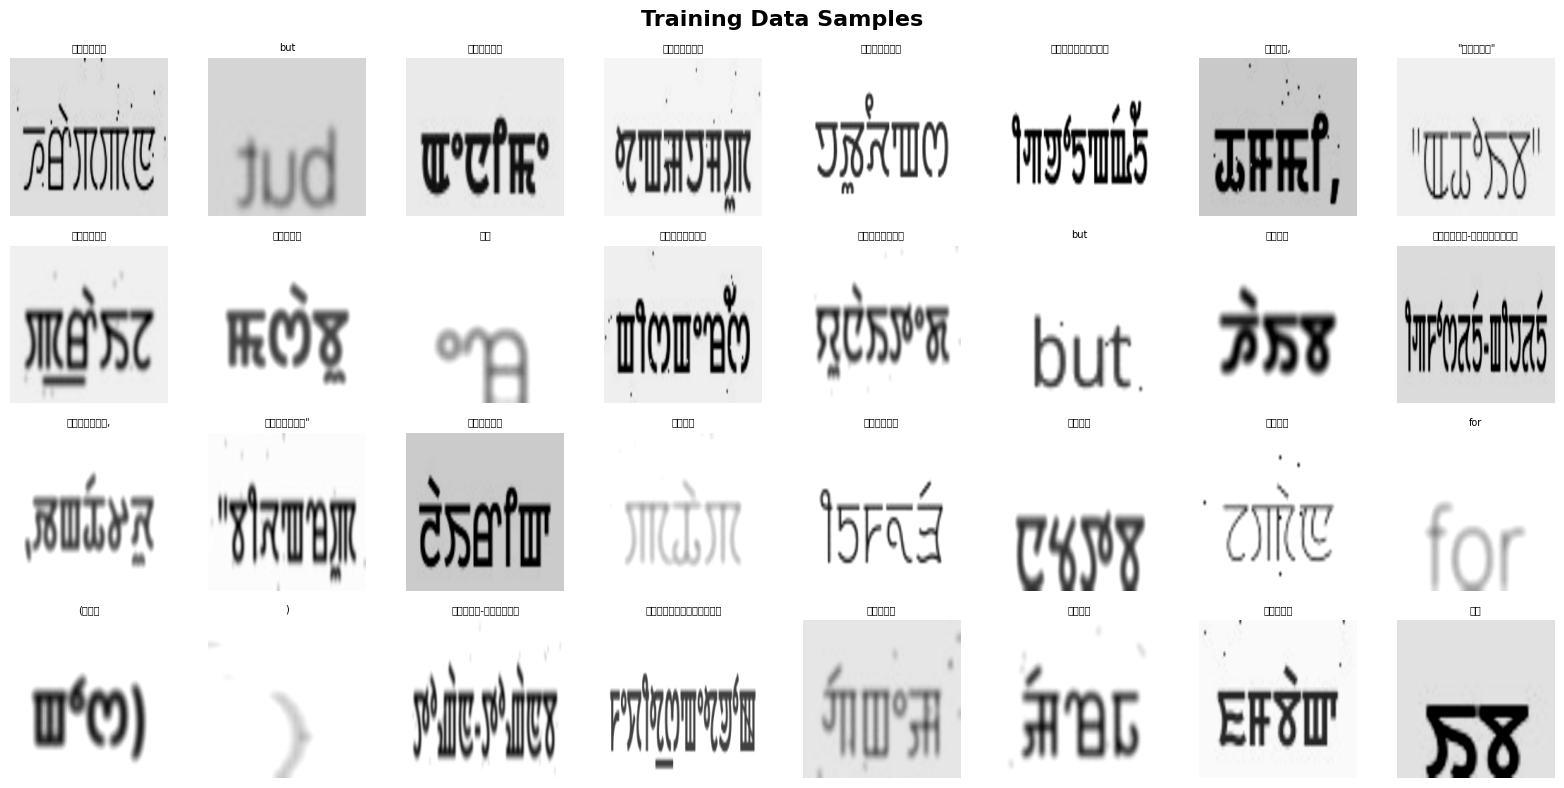


4️⃣  CHECKING FOR DATA LEAKAGE
----------------------------------------------------------------------
✓ Train-Val overlap: 0 files
✓ Train-Test overlap: 0 files
✓ Val-Test overlap: 0 files
   ✅ No data leakage - splits are clean

5️⃣  ANALYZING 14% ACCURACY
----------------------------------------------------------------------
📊 Random guessing accuracy: 0.10%
📊 Your current accuracy: 14%
📊 Ratio vs random: 140.98x

💡 SPECIFIC RECOMMENDATIONS FOR 14% ACCURACY

🔧 IMMEDIATE FIXES:
1. Use MUCH LOWER learning rate:
   Current: 1e-4 → Change to: 1e-5 or 1e-6

2. Unfreeze MORE layers:
   Current: last 20 layers → Change to: last 50-80 layers

3. Train LONGER:
   Current: 50 epochs → Try: 100-150 epochs

4. Use SMALLER batch size:
   Current: 64 → Try: 32 or 16

5. Add CLASS WEIGHTS:
   Add class_weight parameter to model.fit()

✅ DIAGNOSTIC COMPLETE

📋 NEXT STEPS:
1. Review the recommendations above
2. Use the IMPROVED training script I provided
3. Start with these hyperparameters:
   - Lea

In [2]:
"""
STANDALONE DIAGNOSTIC: Debug Low Accuracy
Run this AFTER Block 1 (data loading) but can skip if train_ds doesn't exist yet
"""

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2

print("=" * 70)
print("🔍 DIAGNOSING LOW ACCURACY ISSUE")
print("=" * 70)

# ==================== 1. CHECK VARIABLES EXIST ====================
print("\n1️⃣  CHECKING REQUIRED VARIABLES")
print("-" * 70)

required_vars = ['file_paths_np', 'labels_array_int', 'train_idx', 'val_idx', 
                 'test_idx', 'num_classes', 'le', 'IMG_SIZE']

missing = []
for var in required_vars:
    if var not in globals():
        missing.append(var)
        print(f"❌ Missing: {var}")
    else:
        print(f"✅ Found: {var}")

if missing:
    print(f"\n⚠️  Missing variables: {missing}")
    print("Please run BLOCK 1 (data loading) first!")
    print("\nOr just tell me:")
    print("1. How many images do you have?")
    print("2. How many classes?")
    print("3. What's your current train/val accuracy?")
else:
    print("\n✅ All required variables present")

# If train_ds doesn't exist, create it
if 'train_ds' not in globals():
    print("\n⏳ train_ds not found, checking if we can create it...")
    if 'create_dataset' in globals():
        print("✓ create_dataset function found, creating datasets...")
        BATCH_SIZE = 32
        train_ds = create_dataset(
            file_paths_np[train_idx], 
            labels_array_int[train_idx],
            BATCH_SIZE,
            augment_data=True,
            shuffle_data=True
        )
        val_ds = create_dataset(
            file_paths_np[val_idx], 
            labels_array_int[val_idx],
            BATCH_SIZE
        )
        print("✅ Datasets created!")
    else:
        print("⚠️  Cannot create dataset - create_dataset function not found")
        print("Skipping data pipeline checks...")

# ==================== 2. CHECK LABEL DISTRIBUTION ====================
if 'labels_array_int' in globals() and 'train_idx' in globals():
    print("\n2️⃣  CHECKING LABEL DISTRIBUTION")
    print("-" * 70)

    unique_train_labels = np.unique(labels_array_int[train_idx])
    unique_val_labels = np.unique(labels_array_int[val_idx])
    unique_test_labels = np.unique(labels_array_int[test_idx])

    print(f"✓ Total classes: {num_classes}")
    print(f"✓ Unique labels in train: {len(unique_train_labels)}")
    print(f"✓ Unique labels in val: {len(unique_val_labels)}")
    print(f"✓ Unique labels in test: {len(unique_test_labels)}")

    # Check if all classes present in train
    if len(unique_train_labels) < num_classes:
        missing_classes = num_classes - len(unique_train_labels)
        print(f"❌ NOT ALL CLASSES IN TRAINING! Missing {missing_classes} classes")
        print("   → This will cause 0% accuracy on those classes!")
    else:
        print("✅ All classes present in training")

    # Check class balance
    train_label_counts = np.bincount(labels_array_int[train_idx])
    train_label_counts = train_label_counts[train_label_counts > 0]
    
    print(f"\n📊 Class Balance:")
    print(f"   - Min samples per class: {train_label_counts.min()}")
    print(f"   - Max samples per class: {train_label_counts.max()}")
    print(f"   - Mean samples per class: {train_label_counts.mean():.1f}")
    print(f"   - Imbalance ratio: {train_label_counts.max() / train_label_counts.min():.1f}x")

    if train_label_counts.max() / train_label_counts.min() > 50:
        print("   ❌ SEVERE CLASS IMBALANCE!")
        print("   → Use class_weight in model.fit()")
    elif train_label_counts.max() / train_label_counts.min() > 10:
        print("   ⚠️  Moderate class imbalance")
        print("   → Consider using class_weight")
    else:
        print("   ✅ Classes are reasonably balanced")
    
    # Show top 5 most and least common classes
    class_counts_dict = {}
    for i, count in enumerate(train_label_counts):
        if i < len(le.classes_):
            class_counts_dict[le.classes_[i]] = count
    
    sorted_classes = sorted(class_counts_dict.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\n📊 Top 5 most common classes:")
    for cls, count in sorted_classes[:5]:
        print(f"   - {cls}: {count} samples")
    
    print(f"\n📊 Top 5 least common classes:")
    for cls, count in sorted_classes[-5:]:
        print(f"   - {cls}: {count} samples")

# ==================== 3. CHECK DATA PIPELINE ====================
if 'train_ds' in globals():
    print("\n3️⃣  CHECKING DATA PIPELINE")
    print("-" * 70)

    # Sample a batch
    print("⏳ Sampling batch from training data...")
    sample_batch = next(iter(train_ds))
    sample_images, sample_labels = sample_batch

    print(f"✓ Batch image shape: {sample_images.shape}")
    print(f"✓ Batch label shape: {sample_labels.shape}")
    print(f"✓ Image dtype: {sample_images.dtype}")
    print(f"✓ Label dtype: {sample_labels.dtype}")

    # Check image value ranges
    img_min = tf.reduce_min(sample_images).numpy()
    img_max = tf.reduce_max(sample_images).numpy()
    img_mean = tf.reduce_mean(sample_images).numpy()
    img_std = tf.math.reduce_std(sample_images).numpy()

    print(f"\n📊 Image Statistics:")
    print(f"   - Min value: {img_min:.4f}")
    print(f"   - Max value: {img_max:.4f}")
    print(f"   - Mean value: {img_mean:.4f}")
    print(f"   - Std value: {img_std:.4f}")

    if img_min < -0.1 or img_max > 1.1:
        print("   ❌ WRONG NORMALIZATION!")
        print("   → Images should be in [0, 1] range")
        print("   → Your images are NOT properly normalized!")
    elif img_min >= 0 and img_max <= 1.01:
        print("   ✅ Image normalization looks correct [0, 1]")
    else:
        print("   ⚠️  Image range might be incorrect")

    # Visualize samples
    print("\n⏳ Visualizing sample images...")
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    axes = axes.flatten()

    for i in range(min(32, len(sample_images))):
        img = sample_images[i].numpy()
        label = sample_labels[i].numpy()
        
        # Ensure proper display
        if img.max() <= 1:
            display_img = (img * 255).astype(np.uint8)
        else:
            display_img = img.astype(np.uint8)
        
        axes[i].imshow(display_img)
        axes[i].axis('off')
        
        # Show class name if available
        if 'le' in globals() and label < len(le.classes_):
            class_name = le.classes_[label]
            axes[i].set_title(f'{class_name}', fontsize=7)
        else:
            axes[i].set_title(f'C{label}', fontsize=7)

    plt.suptitle('Training Data Samples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('training_samples.png', dpi=150, bbox_inches='tight')
    print("✓ Saved: training_samples.png")
    plt.show()

# ==================== 4. CHECK FOR DATA LEAKAGE ====================
if 'file_paths_np' in globals():
    print("\n4️⃣  CHECKING FOR DATA LEAKAGE")
    print("-" * 70)

    train_files_set = set(file_paths_np[train_idx])
    val_files_set = set(file_paths_np[val_idx])
    test_files_set = set(file_paths_np[test_idx])

    train_val_overlap = train_files_set & val_files_set
    train_test_overlap = train_files_set & test_files_set
    val_test_overlap = val_files_set & test_files_set

    print(f"✓ Train-Val overlap: {len(train_val_overlap)} files")
    print(f"✓ Train-Test overlap: {len(train_test_overlap)} files")
    print(f"✓ Val-Test overlap: {len(val_test_overlap)} files")

    if len(train_val_overlap) > 0 or len(train_test_overlap) > 0:
        print("   ❌ DATA LEAKAGE DETECTED!")
        print("   → Same files appear in multiple splits!")
    else:
        print("   ✅ No data leakage - splits are clean")

# ==================== 5. ANALYZE YOUR 14% ACCURACY ====================
print("\n5️⃣  ANALYZING 14% ACCURACY")
print("-" * 70)

if 'num_classes' in globals():
    random_accuracy = 100.0 / num_classes
    print(f"📊 Random guessing accuracy: {random_accuracy:.2f}%")
    print(f"📊 Your current accuracy: 14%")
    print(f"📊 Ratio vs random: {14 / random_accuracy:.2f}x")
    
    if 14 < random_accuracy * 2:
        print("\n❌ CRITICAL: Accuracy barely better than random!")
        print("   Most likely causes:")
        print("   1. Learning rate TOO HIGH (model diverged)")
        print("   2. Labels and images DON'T MATCH")
        print("   3. Wrong normalization (images not in [0, 1])")
    elif 14 < random_accuracy * 5:
        print("\n⚠️  Accuracy is low but model IS learning something")
        print("   Most likely causes:")
        print("   1. Learning rate too high")
        print("   2. Not enough trainable layers")
        print("   3. Need more training epochs")

# ==================== 6. RECOMMENDATIONS ====================
print("\n" + "=" * 70)
print("💡 SPECIFIC RECOMMENDATIONS FOR 14% ACCURACY")
print("=" * 70)

print("\n🔧 IMMEDIATE FIXES:")
print("1. Use MUCH LOWER learning rate:")
print("   Current: 1e-4 → Change to: 1e-5 or 1e-6")
print()
print("2. Unfreeze MORE layers:")
print("   Current: last 20 layers → Change to: last 50-80 layers")
print()
print("3. Train LONGER:")
print("   Current: 50 epochs → Try: 100-150 epochs")
print()
print("4. Use SMALLER batch size:")
print("   Current: 64 → Try: 32 or 16")
print()
print("5. Add CLASS WEIGHTS:")
print("   Add class_weight parameter to model.fit()")

if 'train_label_counts' in locals():
    if train_label_counts.max() / train_label_counts.min() > 10:
        print("\n⚠️  YOUR DATA HAS SEVERE CLASS IMBALANCE!")
        print("   This is likely a MAJOR cause of low accuracy")
        print("   → You MUST use class weights!")

print("\n" + "=" * 70)
print("✅ DIAGNOSTIC COMPLETE")
print("=" * 70)

print("\n📋 NEXT STEPS:")
print("1. Review the recommendations above")
print("2. Use the IMPROVED training script I provided")
print("3. Start with these hyperparameters:")
print("   - Learning rate: 1e-5")
print("   - Batch size: 32")
print("   - Epochs: 100")
print("   - Trainable layers: 50")
print("4. Monitor training - should reach 50%+ after 10 epochs")

In [26]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import gc
import time
from sklearn.model_selection import train_test_split

print("\n" + "🚀" * 35)
print("    MEITEI MAYEK OCR - FINAL FIXED RUN")
print("    Status: Wiring Fixed + 70/10/20 Split")
print("🚀" * 35)

# 1. CLEANUP
keras.backend.clear_session()
gc.collect()
keras.mixed_precision.set_global_policy('float32')

# 2. DATA SPLIT (70% Train, 10% Val, 20% Test)
print("\n📊 Splitting Data...")
X_train, X_temp, y_train, y_temp = train_test_split(
    file_paths_np, labels_array_int, 
    test_size=0.30, 
    random_state=42, 
    shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.666, 
    random_state=42
)

print(f"   ✅ Training Set:   {len(X_train)}")
print(f"   ✅ Validation Set: {len(X_val)}")
print(f"   ✅ Test Set:       {len(X_test)}")

# 3. PIPELINES
BATCH_SIZE = 32
IMG_SIZE = 224

def preprocess(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (img / 127.5) - 1.0
    return img, label

print("\n⏳ Creating Pipelines...")
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1000).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print("✅ Pipelines Ready.")

# 4. FIXED MODEL DEFINITION (The Bug Fix)
print("\n⚙️  Compiling MobileNetV2...")

# Load Base (Weights only)
base_model = keras.applications.MobileNetV2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = True

# 🔥 FIXED WIRING:
# We define ONE input variable and use it everywhere.
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Pass that input into the base model
x = base_model(inputs, training=False) # Frozen BN stats

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

# Create Model using the SAME input variable
model = keras.Model(inputs=inputs, outputs=outputs)

# Safe Loss
def safe_sparse_crossentropy(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
    return keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

model.compile(
    optimizer=keras.optimizers.Adam(1e-4), 
    loss=safe_sparse_crossentropy, 
    metrics=['accuracy']
)
print("✅ Model Compiled (Wiring Connected).")

# 5. TRAINING
callbacks = [
    keras.callbacks.ModelCheckpoint('best_meitei_70_10_20.keras', save_best_only=True, monitor='val_accuracy', verbose=1)
]

print(f"\n⚡ STARTING 5 EPOCHS...")
start_time = time.time()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks,
    verbose=1
)

print(f"\n🏁 Done in {(time.time()-start_time)/60:.1f} mins!")

# 6. TEST
print("\n📊 Final Test Evaluation...")
loss, acc = model.evaluate(test_ds)
print(f"🏆 TEST ACCURACY: {acc*100:.2f}%")


🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
    MEITEI MAYEK OCR - FINAL FIXED RUN
    Status: Wiring Fixed + 70/10/20 Split
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀

📊 Splitting Data...
   ✅ Training Set:   70000
   ✅ Validation Set: 10020
   ✅ Test Set:       19980

⏳ Creating Pipelines...
✅ Pipelines Ready.

⚙️  Compiling MobileNetV2...
✅ Model Compiled (Wiring Connected).

⚡ STARTING 5 EPOCHS...
Epoch 1/5
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.4407 - loss: 3.8375
Epoch 1: val_accuracy improved from -inf to 0.99671, saving model to best_meitei_70_10_20.keras
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 309s 122ms/step - accuracy: 0.4408 - loss: 3.8365 - val_accuracy: 0.9967 - val_loss: 0.1291
Epoch 2/5
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9971 - loss: 0.0313
Epoch 2: val_accuracy improved from 0.99671 to 0.99721, saving model to best_meitei_70_10_20.keras
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 243s 111ms/step - accuracy: 0.9971 - loss: 0.0313 - val_accuracy: 0.9972 - val_los

In [9]:
import numpy as np

print("🔍 DATA AUDIT...")
max_label = np.max(labels_array_int)
print(f"📊 Max Label in Data: {max_label}")
print(f"🔢 Number of Classes:   {num_classes}")

if max_label >= num_classes:
    print(f"❌ CRITICAL ERROR: You have label {max_label}, but only {num_classes} classes!")
    print("   Indices must be 0 to", num_classes - 1)
    print("   FIX: Remap your labels or increase num_classes.")
else:
    print("✅ Data Labels look safe. Proceed to training.")

🔍 DATA AUDIT...
📊 Max Label in Data: 1006
🔢 Number of Classes:   1007
✅ Data Labels look safe. Proceed to training.
